In [1]:
import pandas as pd
import numpy as np
import cv2

In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec

In [3]:
!git clone 'https://github.com/millingab/deeps'

Cloning into 'deeps'...
remote: Enumerating objects: 75, done.
remote: Total 75 (delta 0), reused 0 (delta 0), pack-reused 75
Unpacking objects: 100% (75/75), done.


In [4]:
np.random.seed(143)

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
train_images_directory = '/content/drive/MyDrive/Emmen_28_images/images'
train_excel_file_directory = '/content/drive/MyDrive/Emmen_28.xlsx'

In [7]:
df =  pd.read_excel(train_excel_file_directory)
len(df)

2997

In [8]:
for i in range(len(df)):
  df.loc[i, 'image_path'] = train_images_directory + str(df.loc[i, 'cameraRight'][-13:])

In [9]:
def batch_shuffle(dframe):
    """
    Randomly shuffle pairs of rows in the dataframe, separates train and validation data
    generates a uniform random variable 0->9, gives 20% chance to append to valid data, otherwise train_data
    return tuple (train_data, valid_data) dataframes
    """
    randomized_list = np.arange(len(dframe)-1)
    np.random.shuffle(randomized_list)
    
    train_data = pd.DataFrame()
    valid_data = pd.DataFrame()
    
    
    for i in randomized_list:
        idx1 = i
        idx2 = i + 1
        
        row1 = dframe.iloc[[idx1]].reset_index()
        row2 = dframe.iloc[[idx2]].reset_index()
        
        randInt = np.random.randint(10)
        if 0 <= randInt <= 1:
            valid_frames = [valid_data, row1, row2]
            valid_data = pd.concat(valid_frames, axis = 0, join = 'outer', ignore_index=False)
        if randInt >= 2:
            train_frames = [train_data, row1, row2]
            train_data = pd.concat(train_frames, axis = 0, join = 'outer', ignore_index=False)
    return train_data, valid_data

In [10]:
train_data, valid_data = batch_shuffle(df)

In [11]:
train_data = train_data.iloc[:2000]
len(train_data)

2000

In [12]:
def opticalFlowDense(image_current, image_next):
    """
    input: image_current, image_next (RGB images)
    calculates optical flow magnitude and angle and places it into HSV image
    * Set the saturation to the saturation value of image_next
    * Set the hue to the angles returned from computing the flow params
    * set the value to the magnitude returned from computing the flow params
    * Convert from HSV to RGB and return RGB image with same size as original image
    """
    gray_current = cv2.cvtColor(image_current, cv2.COLOR_RGB2GRAY)
    gray_next = cv2.cvtColor(image_next, cv2.COLOR_RGB2GRAY)
    
    hsv = np.zeros(image_current.shape)
    # set saturation
    hsv[:,:,1] = cv2.cvtColor(image_next, cv2.COLOR_RGB2HSV)[:,:,1]
 
    # Flow Parameters
    flow_mat = None
    image_scale = 0.5
    nb_images = 1
    win_size = 15
    nb_iterations = 2
    deg_expansion = 5
    STD = 1.3
    extra = 0

    # obtain dense optical flow paramters
    flow = cv2.calcOpticalFlowFarneback(gray_current, gray_next,  
                                        flow_mat, 
                                        image_scale, 
                                        nb_images, 
                                        win_size, 
                                        nb_iterations, 
                                        deg_expansion, 
                                        STD, 
                                        0)
                                        
        
    # convert from cartesian to polar
    mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])  
        
    # hue corresponds to direction
    hsv[:,:,0] = ang * (180/ np.pi / 2)
    
    # value corresponds to magnitude
    hsv[:,:,2] = cv2.normalize(mag,None,0,255,cv2.NORM_MINMAX)
    
    # convert HSV to float32's
    hsv = np.asarray(hsv, dtype= np.float32)    

    rgb_flow = cv2.cvtColor(hsv,cv2.COLOR_HSV2RGB)

    scale_factor=0.5
    rgb_flow = crop_image(rgb_flow, scale_factor)
    
    return rgb_flow

In [13]:
def crop_image(image, scale):
    """
    preprocesses the image
    
    input: image (480 (y), 640 (x), 3) RGB
    output: image (shape is (66, 220, 3) as RGB)
    
    This stuff is performed on my validation data and my training data
    Process: 
             1) Cropping out black spots
             3) resize to (66, 220, 3) if not done so already from perspective transform
    """
    # Crop out sky (top 130px) and the hood of the car (bottom 270px) 
    image_cropped = image[150:870,:] # -> (240, 640, 3)
    
    height = int(240*scale)
    width = int(640*scale)
    image = cv2.resize(image_cropped, (220, 66), interpolation = cv2.INTER_AREA)
    
    return image

In [14]:
def change_brightness(image, bright_factor):
    """
    Augments the brightness of the image by multiplying the saturation by a uniform random variable
    Input: image (RGB)
    returns: image with brightness augmentation
    """
    
    hsv_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    # perform brightness augmentation only on the second channel
    hsv_image[:,:,2] = hsv_image[:,:,2] * bright_factor
    
    # change back to RGB
    image_rgb = cv2.cvtColor(hsv_image, cv2.COLOR_HSV2RGB)
    return image_rgb

In [15]:
def preprocess_image_from_path(image_path, scale_factor=0.5, bright_factor=1):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # img = change_brightness(img, bright_factor)
    # img = crop_image(img, scale_factor)
    return img

In [16]:
def preprocess_image_valid_from_path(image_path, scale_factor=0.5):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # img = crop_image(img, scale_factor)
    return img

In [17]:
def generate_training_data(data, batch_size = 16, scale_factor = 0.5):
    # sample an image from the data to compute image size
    img = preprocess_image_from_path(train_data.iloc[1]['image_path'])
    img = crop_image(img, scale_factor)

    # create empty batches
    image_batch = np.zeros((batch_size, img.shape[0], img.shape[1], img.shape[2]))
    label_batch = np.zeros(batch_size)
    i=0
    
    while True:
        speed1 = data.iloc[0]['canSpeed']
        speed2 = data.iloc[1]['canSpeed']
        
        bright_factor = 0.2 + np.random.uniform()
        img1 = preprocess_image_from_path(data.iloc[0]['image_path'])
        img2 = preprocess_image_from_path(data.iloc[1]['image_path'])
        
        rgb_flow_diff = opticalFlowDense(img1, img2)
        avg_speed = np.mean([speed1,speed2])
        
        image_batch[(i//2)%batch_size] = rgb_flow_diff
        label_batch[(i//2)%batch_size] = avg_speed
        
        if not(((i//2)+1)%batch_size):
            yield image_batch, label_batch
        i+=2
        i=i%data.shape[0]

In [18]:
def generate_validation_data(data, batch_size = 16, scale_factor = 0.5):
    i=0
    while i < len(data):
        speed1 = data.iloc[0]['canSpeed']
        speed2 = data.iloc[1]['canSpeed']
    
        img1 = preprocess_image_valid_from_path(data.iloc[0]['image_path'])
        img2 = preprocess_image_valid_from_path(data.iloc[1]['image_path'])
        
        rgb_diff = opticalFlowDense(img1, img2)
        rgb_diff = rgb_diff.reshape(1, rgb_diff.shape[0], rgb_diff.shape[1], rgb_diff.shape[2])
        avg_speed = np.array([[np.mean([speed1,speed2])]])

        yield rgb_diff, avg_speed

In [19]:
from tensorflow import keras
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.core import Activation, Dropout, Flatten, Dense, Lambda
from keras.layers import ELU
# from tensorflow.keras.optimizers import Adam
import keras.backend as KTF


N_img_height = 66
N_img_width = 220
N_img_channels = 3
def nvidia_model():
    inputShape = (N_img_height, N_img_width, N_img_channels)

    model = Sequential()
    # normalization    
    # perform custom normalization before lambda layer in network
    model.add(Lambda(lambda x: x/ 127.5 - 1, input_shape = inputShape))

    model.add(Convolution2D(24, (5, 5), 
                            strides=(2,2), 
                            padding = 'valid',
                            kernel_initializer = 'he_normal',
                            name = 'conv1'))
    
    
    model.add(ELU())    
    model.add(Convolution2D(36, (5, 5), 
                            strides=(2,2), 
                            padding = 'valid',
                            kernel_initializer = 'he_normal',
                            name = 'conv2'))
    
    model.add(ELU())    
    model.add(Convolution2D(48, (5, 5), 
                            strides=(2,2), 
                            padding = 'valid',
                            kernel_initializer = 'he_normal',
                            name = 'conv3'))
    model.add(ELU())
    model.add(Dropout(0.5))
    model.add(Convolution2D(64, (3, 3), 
                            strides = (1,1), 
                            padding = 'valid',
                            kernel_initializer = 'he_normal',
                            name = 'conv4'))
    
    model.add(ELU())              
    model.add(Convolution2D(64, (3, 3), 
                            strides= (1,1), 
                            padding = 'valid',
                            kernel_initializer = 'he_normal',
                            name = 'conv5'))
              
              
    model.add(Flatten(name = 'flatten'))
    model.add(ELU())
    model.add(Dense(100, kernel_initializer = 'he_normal', name = 'fc1'))
    model.add(ELU())
    model.add(Dense(50, kernel_initializer = 'he_normal', name = 'fc2'))
    model.add(ELU())
    model.add(Dense(10, kernel_initializer = 'he_normal', name = 'fc3'))
    model.add(ELU())
    
    # do not put activation at the end because we want to exact output, not a class identifier
    model.add(Dense(1, name = 'output', kernel_initializer = 'he_normal'))
    
    adam = keras.optimizers.Adam(learning_rate=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    model.compile(optimizer = adam, loss = 'mse')

    return model

In [20]:
val_size = len(train_data[:500].index)
valid_generator = generate_validation_data(train_data[:500])
BATCH = 16
print('val_size: ', val_size)

val_size:  500


In [21]:
train_size = len(train_data.index)
print('train_size: ', train_size)

train_size:  2000


In [22]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
filepath = '/content/drive/MyDrive/sanity_check/model-weights.h5'
earlyStopping = EarlyStopping(monitor='val_loss', 
                              patience=5, 
                              verbose=1, 
                              min_delta = 0.23,
                              mode='min')
modelCheckpoint = ModelCheckpoint(filepath, 
                                  monitor = 'val_loss', 
                                  save_best_only = True, 
                                  mode = 'min', 
                                  verbose = 1,
                                 save_weights_only = True)
callbacks_list = [earlyStopping, modelCheckpoint]

In [23]:
model = nvidia_model()
model.load_weights('/content/deeps/model-weights-Vtest3.h5')

In [24]:
train_generator = generate_training_data(train_data, BATCH)
history = model.fit(
        train_generator, 
        steps_per_epoch = 400, 
        epochs = 10,
        callbacks = callbacks_list,
        verbose = 1,
        validation_data = valid_generator,
        validation_steps = val_size)

print(history)

Epoch 1/10
400/400 [==============================] - ETA: 0s - loss: 0.2339
Epoch 1: val_loss improved from inf to 0.00573, saving model to /content/drive/MyDrive/sanity_check/model-weights.h5
400/400 [==============================] - 3219s 8s/step - loss: 0.2339 - val_loss: 0.0057
Epoch 2/10
400/400 [==============================] - ETA: 0s - loss: 0.0273
Epoch 2: val_loss improved from 0.00573 to 0.00572, saving model to /content/drive/MyDrive/sanity_check/model-weights.h5
400/400 [==============================] - 3341s 8s/step - loss: 0.0273 - val_loss: 0.0057
Epoch 3/10
400/400 [==============================] - ETA: 0s - loss: 0.0145
Epoch 3: val_loss improved from 0.00572 to 0.00411, saving model to /content/drive/MyDrive/sanity_check/model-weights.h5
400/400 [==============================] - 3353s 8s/step - loss: 0.0145 - val_loss: 0.0041
Epoch 4/10
400/400 [==============================] - ETA: 0s - loss: 0.0092
Epoch 4: val_loss improved from 0.00411 to 0.00161, saving m

dict_keys(['loss', 'val_loss'])


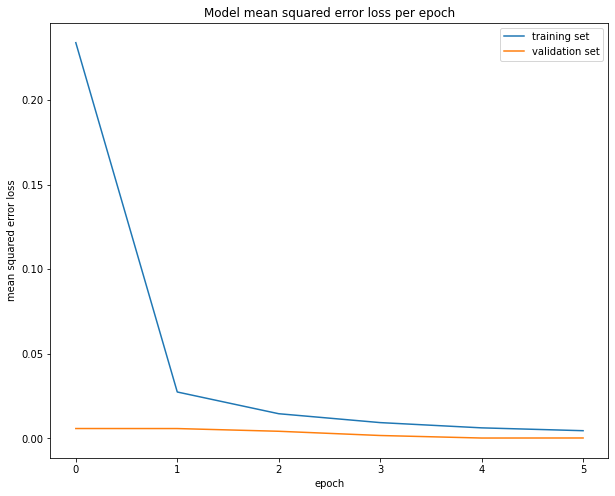

In [25]:
print(history.history.keys())

### plot the training and validation loss for each epoch
plt.figure(figsize=[10,8])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model mean squared error loss per epoch')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()

In [26]:
model.load_weights('/content/drive/MyDrive/sanity_check/model-weights.h5')

In [27]:
import os
predict_speed = []
labels = []
test_size = int(0.2 * len(train_data[:2500]))
test_size

400

In [28]:
for i in range(test_size):
    
    # print(index)
    y1 = train_data.iloc[0]['canSpeed']
    y2 = train_data.iloc[1]['canSpeed']
    avg_speed =np.mean([y1,y2])
    # print(avg_speed)
    # break
    x1 = preprocess_image_valid_from_path(train_data.iloc[0]['image_path'])
    x2 = preprocess_image_valid_from_path(train_data.iloc[1]['image_path'])
    
    rgb_diff = opticalFlowDense(x1, x2)
    rgb_diff = rgb_diff.reshape(1, rgb_diff.shape[0], rgb_diff.shape[1], rgb_diff.shape[2])

    prediction = model.predict(rgb_diff)
    predict_speed.append(float(prediction[0]))
    labels.append(avg_speed)

In [29]:
from sklearn.metrics import mean_squared_error
mean_squared_error(labels, predict_speed)

0.0001129644914158261

In [30]:

from sklearn.metrics import r2_score
r2_score(labels, predict_speed)

-9.164768342255912e+27

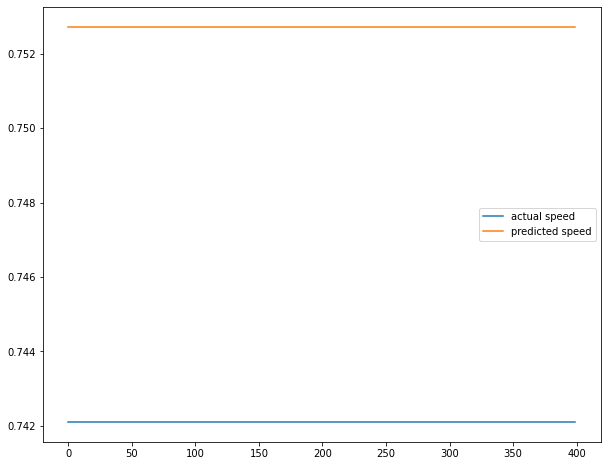

In [31]:
plt.figure(figsize=[10,8])
plt.plot(range(test_size), labels, label='actual speed')
plt.plot(range(test_size), predict_speed, label='predicted speed')
plt.legend()
plt.show()